In [9]:
!pip install gtsam
!pip install apriltag

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import apriltag
import gtsam

fu = 1473.33782
cu = 932.919082
fv = 1478.71754
cv = 552.331097

M = 24

dataset_path = '/content/drive/MyDrive/vslam/vslam/'
num_images = 500

options = apriltag.DetectorOptions()
detector = apriltag.Detector(options)

graph = gtsam.NonlinearFactorGraph()
initial_values = gtsam.Values()

noise_model = gtsam.noiseModel.Isotropic.Sigma(6, 1.0)

graph.add(gtsam.PriorFactorPose3(gtsam.symbol('Y', 0), gtsam.Pose3(), gtsam.noiseModel.Constrained.All(6)))



for i in range(num_images):
    image_path = dataset_path + "frame_" + f'{i}.jpg'

    # Load the image and check if it is successfully loaded
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error loading image: {image_path}")
        continue

    tags = detector.detect(image)

    for tag in tags:
        tag_id = tag.tag_id

        if tag_id  >=0  and  tag_id < M:
            pose, eo, e1 = detector.detection_pose(tag, [fu, fv, cu, cv], 0.5)

            factor = gtsam.BetweenFactorPose3(
                gtsam.symbol('X', i),
                gtsam.symbol('Y', tag_id),
                gtsam.Pose3(pose),
                noise_model
            )
            graph.add(factor)

for i in range(0,24):
  initial_values.insert(gtsam.symbol('Y',i),gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(i,i,0)))

for i in range(num_images):
  initial_values.insert(gtsam.symbol('X', i),gtsam.Pose3())


params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_values, params)

result = optimizer.optimize()

optimized_camera_pose = [result.atPose3(gtsam.symbol('X',i)) for i in range(num_images)]
optimized_tag_pose = [result.atPose3(gtsam.symbol('Y', j)) for j in range(0,M)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


#for camera pose
for i,pose in enumerate(optimized_camera_pose):
  ax.scatter(-pose.x(), pose.y(), -pose.z(), c = 'blue', marker='o')


#for tag pose
for j,pose in enumerate(optimized_tag_pose):
  ax.scatter(-pose.x(), pose.y(), -pose.z(), c = 'red', marker='+')
  ax.text(-pose.x(),pose.y(),-pose.z(), f'Tag {j}',color='red', fontsize=8)


# plt.gca().invert_zaxis()
ax.set_ylabel('Y-axis')
ax.set_xlabel('X-axis')
ax.set_zlabel('Z-axis')
ax.view_init(azim=45)
ax.set_title('Estimated positions of Camera and AprilTags')

plt.show()


KeyboardInterrupt: ignored

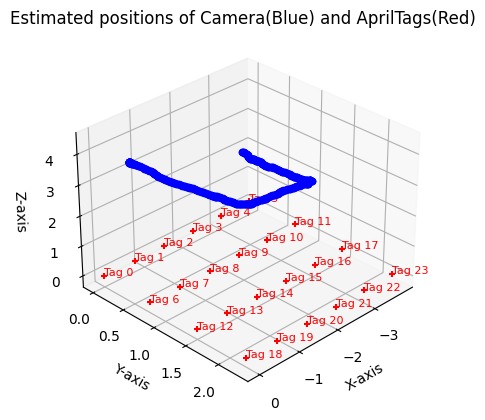

In [38]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import apriltag
import gtsam

# Camera intrinsic parameters
focal_length_x = 1476.36024
focal_length_y = 1482.18267
principal_point_x = 979.133964
principal_point_y = 552.332448

# Number of tags
num_tags = 24

# Dataset path and number of images
dataset_path = '/content/drive/MyDrive/vslam/vslam/'
num_images = 500

# AprilTag detector initialization
options = apriltag.DetectorOptions()
tag_detector = apriltag.Detector(options)

# Create a factor graph and initial values
factor_graph = gtsam.NonlinearFactorGraph()
initial_values = gtsam.Values()

# Noise model for factors
noise_model = gtsam.noiseModel.Isotropic.Sigma(6, 1.0)

# Add a prior factor for the first tag pose
factor_graph.add(gtsam.PriorFactorPose3(gtsam.symbol('Y', 0), gtsam.Pose3(), gtsam.noiseModel.Constrained.All(6)))

# Loop through the images using a while loop
image_index = 0
while image_index < num_images:
    image_path = dataset_path + f"frame_{image_index}.jpg"

    # Load the image and check if it is successfully loaded
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error loading image: {image_path}")
        continue

    # Detect AprilTags in the image
    detected_tags = tag_detector.detect(image)

    # Loop through detected tags using a while loop
    tag_index = 0
    while tag_index < len(detected_tags):
        tag = detected_tags[tag_index]
        tag_id = tag.tag_id

        if 0 <= tag_id < num_tags:
            # Get the pose of the detected tag
            tag_pose, _, _ = tag_detector.detection_pose(tag, [focal_length_x, focal_length_y, principal_point_x, principal_point_y], 0.5)

            # Add a factor for the relative pose between camera and tag
            factor = gtsam.BetweenFactorPose3(
                gtsam.symbol('X', image_index),
                gtsam.symbol('Y', tag_id),
                gtsam.Pose3(tag_pose),
                noise_model
            )
            factor_graph.add(factor)

        tag_index += 1

    image_index += 1

# Initialize tag poses using a while loop
tag_index = 0
while tag_index < num_tags:
    initial_values.insert(gtsam.symbol('Y', tag_index), gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(tag_index, tag_index, 0)))
    tag_index += 1

# Initialize image poses using a while loop
image_index = 0
while image_index < num_images:
    initial_values.insert(gtsam.symbol('X', image_index), gtsam.Pose3())
    image_index += 1

# Configure Levenberg-Marquardt optimizer
optimizer_params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(factor_graph, initial_values, optimizer_params)

# Optimize the factor graph
result = optimizer.optimize()

# Extract optimized camera and tag poses
optimized_camera_poses = [result.atPose3(gtsam.symbol('X', i)) for i in range(num_images)]
optimized_tag_poses = [result.atPose3(gtsam.symbol('Y', j)) for j in range(num_tags)]

# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot camera poses using a while loop
image_index = 0
while image_index < len(optimized_camera_poses):
    camera_pose = optimized_camera_poses[image_index]
    ax.scatter(-camera_pose.x(), camera_pose.y(), -camera_pose.z(), c='blue', marker='o')
    image_index += 1

# Plot tag poses using a while loop
tag_index = 0
while tag_index < len(optimized_tag_poses):
    tag_pose = optimized_tag_poses[tag_index]
    ax.scatter(-tag_pose.x(), tag_pose.y(), -tag_pose.z(), c='red', marker='+')
    ax.text(-tag_pose.x(), tag_pose.y(), -tag_pose.z(), f'Tag {tag_index}', color='red', fontsize=8)
    tag_index += 1

# Set axis labels and title
ax.set_ylabel('Y-axis')
ax.set_xlabel('X-axis')
ax.set_zlabel('Z-axis')
ax.view_init(azim=45)
ax.set_title('Estimated positions of Camera(Blue) and AprilTags(Red)')

# Show the plot
plt.show()

